# Home Credit Default Risk - Feature Engineering

**Project:** AI-Powered Intelligent Risk Management System  
**Dataset:** [Kaggle - Home Credit Default Risk](https://www.kaggle.com/competitions/home-credit-default-risk)  
**Objective:** Engineer new features from the application table and clean known data anomalies before auxiliary-table aggregation.

---

## Table of Contents
1. [Libraries & Configuration](#1)
2. [Data Loading](#2)
3. [Step 1 — Application Table: Derived Features](#3)
4. [Step 2 — DAYS_EMPLOYED Anomaly Cleanup](#4)
5. [Validation & Summary](#5)

<a id='1'></a>
## 1. Libraries & Configuration

In [1]:
import sys
import os
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Add project root to path for local imports
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), '..'))
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

from src.utils import reduce_memory_usage, load_dataset
from src.feature_engineering import (
    engineer_application_features,
    fix_days_employed_anomaly,
)

# Visualization settings
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 12
sns.set_palette('husl')

# Pandas display
pd.set_option('display.max_columns', 50)
pd.set_option('display.float_format', '{:.2f}'.format)

DATA_DIR = os.path.join(PROJECT_ROOT, 'docs', 'dataset')
PLOT_DIR = os.path.join(os.getcwd(), 'plots')
os.makedirs(PLOT_DIR, exist_ok=True)

print(f"Data directory : {DATA_DIR}")
print(f"Plot directory : {PLOT_DIR}")

Data directory : C:\Users\busra\Projects\Ai_Credit_Risk\docs\dataset
Plot directory : C:\Users\busra\Projects\Ai_Credit_Risk\notebooks\plots


<a id='2'></a>
## 2. Data Loading

For feature engineering validation we load only `application_train`  
(with 20% sampling for fast iteration).

In [2]:
# Load only the main application table for now
df = pd.read_csv(os.path.join(DATA_DIR, 'application_train.csv'))
df = df.sample(frac=0.2, random_state=42).reset_index(drop=True)
df = reduce_memory_usage(df, verbose=True)

print(f"\nShape: {df.shape}")
print(f"Columns: {df.shape[1]}")
df.head(3)

  Memory usage: 107.4 MB -> 75.7 MB (29.4% reduction)

Shape: (61502, 122)
Columns: 122


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,...,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,384575,0,Cash loans,M,Y,N,2,207000.00,465457.50,52641.00,418500.00,Unaccompanied,Commercial associate,Secondary / secondary special,Married,House / apartment,0.01,-13297,-762,-637.00,-4307,19.00,1,1,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,0.00,0.00,1.00,0.00,1.00
1,214010,0,Cash loans,F,Y,Y,0,247500.00,1281712.50,48946.50,1179000.00,Unaccompanied,Commercial associate,Higher education,Single / not married,House / apartment,0.01,-14778,-1141,-1610.00,-4546,11.00,1,1,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,0.00,0.00,1.00,0.00,3.00
2,142232,0,Cash loans,F,Y,N,0,202500.00,495000.00,39109.50,495000.00,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.04,-17907,-639,-2507.00,-1461,4.00,1,1,1,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,0.00,0.00,1.00,0.00,3.00


<a id='3'></a>
## 3. Step 1 — Application Table: Derived Features

We create new features purely from the application table's existing columns.
These are row-level transformations (no joins), so they run fast.

| Feature | Formula | Rationale |
|---|---|---|
| `CREDIT_INCOME_RATIO` | AMT_CREDIT / AMT_INCOME_TOTAL | Loan size relative to income — high values signal risk |
| `ANNUITY_INCOME_RATIO` | AMT_ANNUITY / AMT_INCOME_TOTAL | Monthly payment burden |
| `CREDIT_TERM` | AMT_CREDIT / AMT_ANNUITY | Estimated repayment duration (months) |
| `GOODS_CREDIT_DIFF` | AMT_GOODS_PRICE - AMT_CREDIT | Down-payment proxy — negative means over-financing |
| `INCOME_PER_CHILD` | AMT_INCOME_TOTAL / CNT_CHILDREN | Income load per dependent |
| `INCOME_PER_FAMILY` | AMT_INCOME_TOTAL / CNT_FAM_MEMBERS | Income per household member |
| `AGE_YEARS` | -DAYS_BIRTH / 365.25 | Human-readable age |
| `EMPLOYED_YEARS` | -DAYS_EMPLOYED / 365.25 | Employment tenure |
| `REGISTRATION_YEARS` | -DAYS_REGISTRATION / 365.25 | Time since ID registration |
| `HAS_CAR` | 1 if OWN_CAR_AGE is not null | Car ownership flag |

In [3]:
original_cols = df.columns.tolist()

df = engineer_application_features(df)

new_cols = [c for c in df.columns if c not in original_cols]
print(f"New features added: {len(new_cols)}")
print(f"  -> {new_cols}")
print(f"Total columns: {df.shape[1]}")

New features added: 10
  -> ['CREDIT_INCOME_RATIO', 'ANNUITY_INCOME_RATIO', 'CREDIT_TERM', 'GOODS_CREDIT_DIFF', 'INCOME_PER_CHILD', 'INCOME_PER_FAMILY', 'AGE_YEARS', 'EMPLOYED_YEARS', 'REGISTRATION_YEARS', 'HAS_CAR']
Total columns: 132


In [4]:
# Quick look at the new features
df[new_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
CREDIT_INCOME_RATIO,61502.00,3.95,2.67,0.00,2.02,3.27,5.15,36.69
ANNUITY_INCOME_RATIO,61500.00,0.18,0.09,0.00,0.11,0.16,0.23,1.57
CREDIT_TERM,61500.00,21.58,7.80,8.04,15.61,20.00,26.98,45.30
GOODS_CREDIT_DIFF,61448.00,-60782.33,70032.22,-445500.00,-99792.00,-39442.50,0.00,652500.00
INCOME_PER_CHILD,61502.00,160823.00,483227.03,10950.00,96750.00,135000.00,202500.00,117000000.00
INCOME_PER_FAMILY,61501.00,93694.01,173136.88,6570.00,47250.00,75000.00,112500.00,39000000.00
AGE_YEARS,61502.00,43.89,11.98,21.00,33.90,43.10,53.90,69.00
EMPLOYED_YEARS,61502.00,-174.31,386.47,-1000.00,0.80,3.30,7.60,48.00
REGISTRATION_YEARS,61502.00,13.66,9.66,0.00,5.50,12.30,20.40,67.50
HAS_CAR,61502.00,0.34,0.47,0.00,0.00,0.00,1.00,1.00


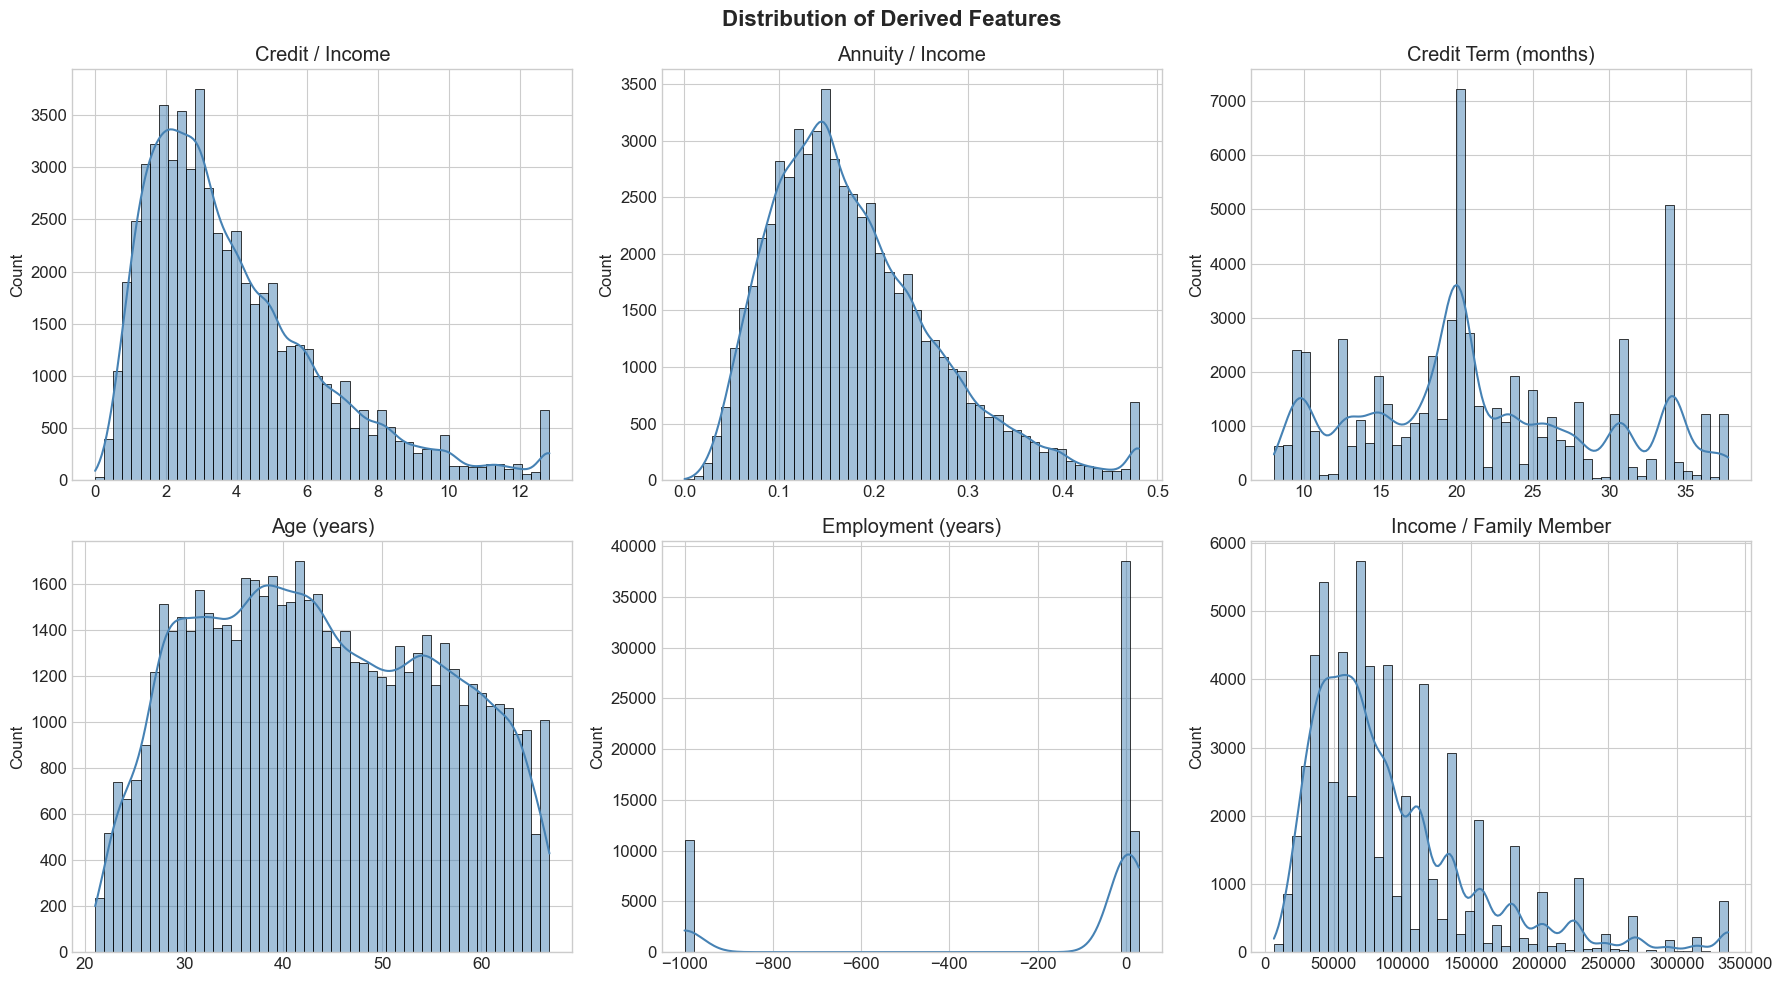

Saved: derived_features_dist.png


In [5]:
# Visualize distributions of key derived features
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Distribution of Derived Features', fontsize=16, fontweight='bold')

plot_features = [
    ('CREDIT_INCOME_RATIO', 'Credit / Income'),
    ('ANNUITY_INCOME_RATIO', 'Annuity / Income'),
    ('CREDIT_TERM', 'Credit Term (months)'),
    ('AGE_YEARS', 'Age (years)'),
    ('EMPLOYED_YEARS', 'Employment (years)'),
    ('INCOME_PER_FAMILY', 'Income / Family Member'),
]

for ax, (feat, title) in zip(axes.flat, plot_features):
    # Clip extreme outliers for visualization
    data = df[feat].clip(upper=df[feat].quantile(0.99))
    sns.histplot(data, ax=ax, kde=True, bins=50, color='steelblue')
    ax.set_title(title)
    ax.set_xlabel('')

plt.tight_layout()
plt.savefig(os.path.join(PLOT_DIR, 'derived_features_dist.png'), dpi=150, bbox_inches='tight')
plt.show()
print('Saved: derived_features_dist.png')

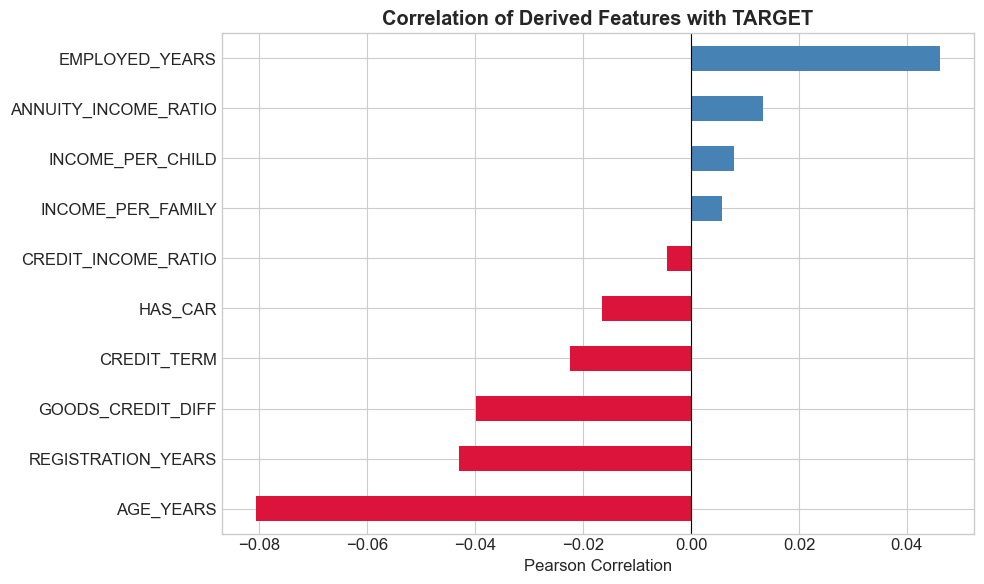

Saved: derived_features_target_corr.png


In [6]:
# Correlation of new features with TARGET
target_corr = df[['TARGET'] + new_cols].corr()['TARGET'].drop('TARGET').sort_values()

fig, ax = plt.subplots(figsize=(10, 6))
colors = ['crimson' if v < 0 else 'steelblue' for v in target_corr.values]
target_corr.plot.barh(ax=ax, color=colors)
ax.set_title('Correlation of Derived Features with TARGET', fontweight='bold')
ax.set_xlabel('Pearson Correlation')
ax.axvline(x=0, color='black', linewidth=0.8)
plt.tight_layout()
plt.savefig(os.path.join(PLOT_DIR, 'derived_features_target_corr.png'), dpi=150, bbox_inches='tight')
plt.show()
print('Saved: derived_features_target_corr.png')

<a id='4'></a>
## 4. Step 2 — DAYS_EMPLOYED Anomaly Cleanup

The EDA revealed that **DAYS_EMPLOYED** contains a sentinel value of **365,243**  
(equivalent to ~1,000 years) for clients who are not employed (retired, unemployed, etc.).  
This affects roughly **18%** of all records and will distort any model that uses this column.

**Strategy:**
1. Create a binary flag `DAYS_EMPLOYED_ANOMALY` (captures information that the value was missing).
2. Replace 365,243 with `NaN`, then fill with the median of valid records.
3. Recalculate `EMPLOYED_YEARS` after cleanup.

=== BEFORE CLEANUP ===
DAYS_EMPLOYED range : [-17522, 365243]
EMPLOYED_YEARS range: [-1000.0, 48.0]
Anomalous rows      : 11,050 (18.0%)


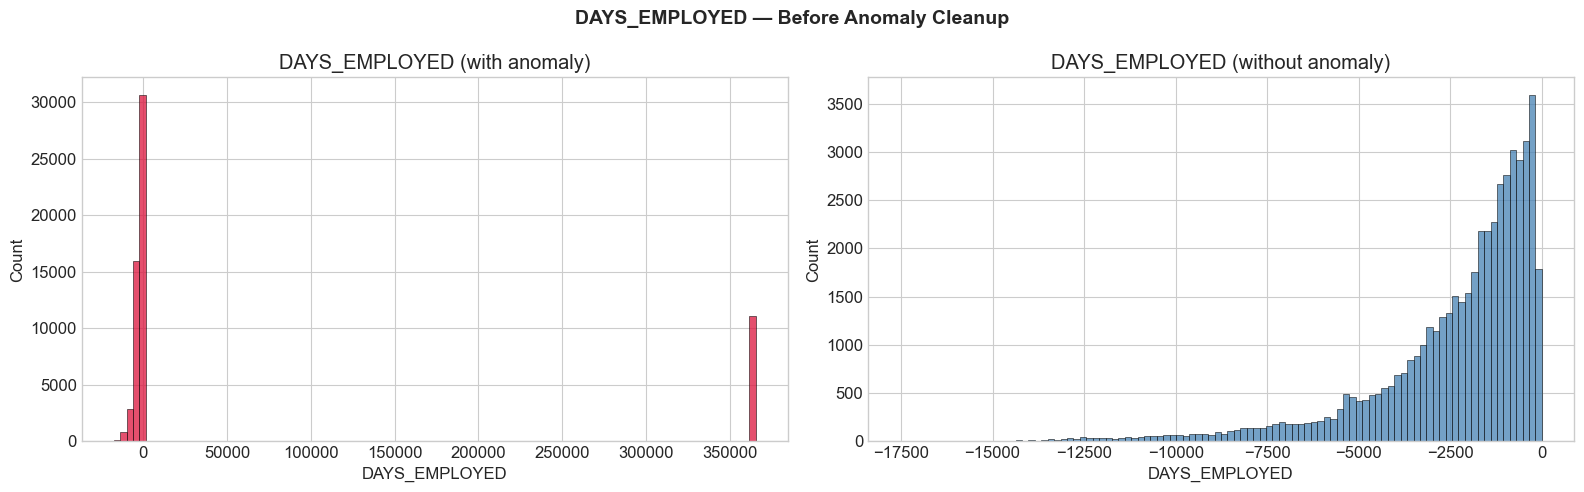

In [7]:
# Before cleanup: check the anomaly
print('=== BEFORE CLEANUP ===')
print(f"DAYS_EMPLOYED range : [{df['DAYS_EMPLOYED'].min():.0f}, {df['DAYS_EMPLOYED'].max():.0f}]")
print(f"EMPLOYED_YEARS range: [{df['EMPLOYED_YEARS'].min():.1f}, {df['EMPLOYED_YEARS'].max():.1f}]")

anomaly_mask = df['DAYS_EMPLOYED'] == 365243
print(f"Anomalous rows      : {anomaly_mask.sum():,} ({anomaly_mask.mean()*100:.1f}%)")

# Visualize BEFORE
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
fig.suptitle('DAYS_EMPLOYED — Before Anomaly Cleanup', fontsize=14, fontweight='bold')

sns.histplot(df['DAYS_EMPLOYED'], ax=axes[0], bins=100, color='crimson')
axes[0].set_title('DAYS_EMPLOYED (with anomaly)')

sns.histplot(df.loc[~anomaly_mask, 'DAYS_EMPLOYED'], ax=axes[1], bins=100, color='steelblue')
axes[1].set_title('DAYS_EMPLOYED (without anomaly)')

plt.tight_layout()
plt.savefig(os.path.join(PLOT_DIR, 'days_employed_before.png'), dpi=150, bbox_inches='tight')
plt.show()

In [8]:
# Apply the fix
df = fix_days_employed_anomaly(df)

print(f"\n=== AFTER CLEANUP ===")
print(f"DAYS_EMPLOYED range : [{df['DAYS_EMPLOYED'].min():.0f}, {df['DAYS_EMPLOYED'].max():.0f}]")
print(f"EMPLOYED_YEARS range: [{df['EMPLOYED_YEARS'].min():.1f}, {df['EMPLOYED_YEARS'].max():.1f}]")
print(f"DAYS_EMPLOYED_ANOMALY distribution:")
print(df['DAYS_EMPLOYED_ANOMALY'].value_counts())

  DAYS_EMPLOYED anomaly: 11,050 rows (18.0%) replaced with NaN
  DAYS_EMPLOYED NaN filled with median: -1653 days

=== AFTER CLEANUP ===
DAYS_EMPLOYED range : [-17522, -2]
EMPLOYED_YEARS range: [0.0, 48.0]
DAYS_EMPLOYED_ANOMALY distribution:
DAYS_EMPLOYED_ANOMALY
0    50452
1    11050
Name: count, dtype: int64


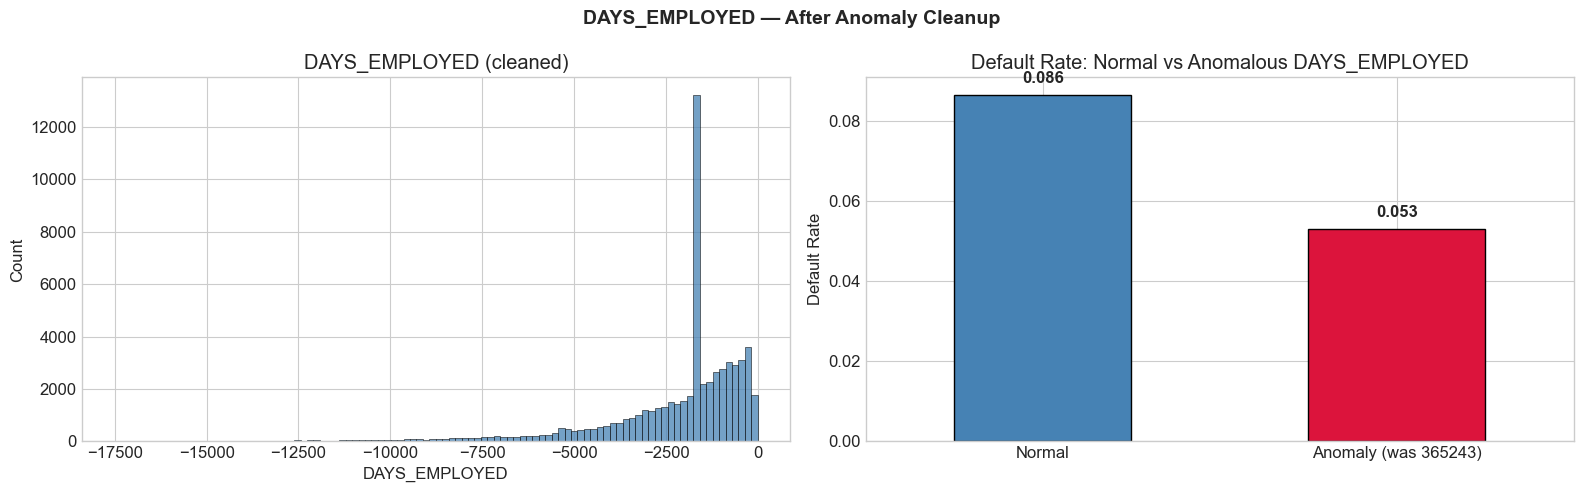

Saved: days_employed_before.png, days_employed_after.png


In [9]:
# Visualize AFTER
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
fig.suptitle('DAYS_EMPLOYED — After Anomaly Cleanup', fontsize=14, fontweight='bold')

sns.histplot(df['DAYS_EMPLOYED'], ax=axes[0], bins=100, color='steelblue')
axes[0].set_title('DAYS_EMPLOYED (cleaned)')

# Compare default rates: anomalous vs normal
anomaly_rates = df.groupby('DAYS_EMPLOYED_ANOMALY')['TARGET'].mean()
anomaly_rates.index = ['Normal', 'Anomaly (was 365243)']
anomaly_rates.plot.bar(ax=axes[1], color=['steelblue', 'crimson'], edgecolor='black')
axes[1].set_title('Default Rate: Normal vs Anomalous DAYS_EMPLOYED')
axes[1].set_ylabel('Default Rate')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=0)

for i, v in enumerate(anomaly_rates.values):
    axes[1].text(i, v + 0.003, f'{v:.3f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig(os.path.join(PLOT_DIR, 'days_employed_after.png'), dpi=150, bbox_inches='tight')
plt.show()
print('Saved: days_employed_before.png, days_employed_after.png')

<a id='5'></a>
## 5. Validation & Summary

In [10]:
# Final summary of all new / modified columns
all_new_cols = new_cols + ['DAYS_EMPLOYED_ANOMALY']
print(f'Total new features: {len(all_new_cols)}')
print(f'Total columns now : {df.shape[1]}')
print(f'Shape             : {df.shape}')
print()

# Check for NaN in new features
nan_check = df[all_new_cols].isnull().sum()
nan_check = nan_check[nan_check > 0]
if len(nan_check) == 0:
    print('No NaN values in any new feature column.')
else:
    print('NaN values found in new features:')
    print(nan_check)

print()
print('--- New Features Statistics ---')
df[all_new_cols].describe().T

Total new features: 11
Total columns now : 133
Shape             : (61502, 133)

NaN values found in new features:
ANNUITY_INCOME_RATIO     2
CREDIT_TERM              2
GOODS_CREDIT_DIFF       54
INCOME_PER_FAMILY        1
dtype: int64

--- New Features Statistics ---


,count,mean,std,min,25%,50%,75%,max
CREDIT_INCOME_RATIO,61502.00,3.95,2.67,0.00,2.02,3.27,5.15,36.69
ANNUITY_INCOME_RATIO,61500.00,0.18,0.09,0.00,0.11,0.16,0.23,1.57
CREDIT_TERM,61500.00,21.58,7.80,8.04,15.61,20.00,26.98,45.30
GOODS_CREDIT_DIFF,61448.00,-60782.33,70032.22,-445500.00,-99792.00,-39442.50,0.00,652500.00
INCOME_PER_CHILD,61502.00,160823.00,483227.03,10950.00,96750.00,135000.00,202500.00,117000000.00
INCOME_PER_FAMILY,61501.00,93694.01,173136.88,6570.00,47250.00,75000.00,112500.00,39000000.00
AGE_YEARS,61502.00,43.89,11.98,21.00,33.90,43.10,53.90,69.00
EMPLOYED_YEARS,61502.00,6.17,5.84,0.00,2.60,4.50,7.60,48.00
REGISTRATION_YEARS,61502.00,13.66,9.66,0.00,5.50,12.30,20.40,67.50
HAS_CAR,61502.00,0.34,0.47,0.00,0.00,0.00,1.00,1.00


### Key Observations

**Step 1 — Derived Features:**
- `CREDIT_INCOME_RATIO` and `ANNUITY_INCOME_RATIO` capture financial burden and are expected to be strong predictors.
- `CREDIT_TERM` shows the estimated loan duration; very long terms may indicate higher risk.
- `GOODS_CREDIT_DIFF` reveals whether clients are financing more than the goods price (negative = over-financing).
- `HAS_CAR` is a clean binary feature derived from a mostly-null `OWN_CAR_AGE` column.

**Step 2 — DAYS_EMPLOYED Anomaly:**
- ~18% of records had the sentinel value 365,243 — now flagged in `DAYS_EMPLOYED_ANOMALY`.
- This flag itself may be predictive: anomalous clients could have a different default profile.
- After median imputation, `EMPLOYED_YEARS` has a realistic distribution.

---

### Next Steps

- **Step 3:** Bureau table aggregations (external credit history)
- **Step 4:** Previous application aggregations
- **Step 5:** Installments & credit card balance aggregations
- **Step 6:** Merge all features into a single training DataFrame